In [ ]:
import os, random, math, warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve
)

In [ ]:
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

In [ ]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/creditcard.csv')
print("Dataset shape:", df.shape)
assert "Class" in df.columns, "Expected 'Class' column."

Dataset shape: (284807, 31)


In [ ]:
def section(title):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))


Class distribution
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


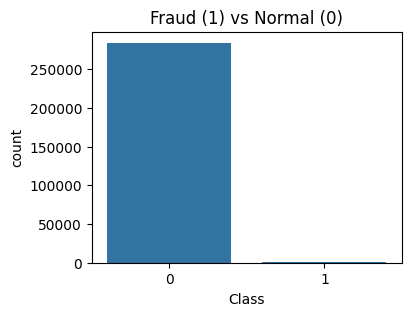

In [ ]:
section("Class distribution")
print(df["Class"].value_counts(normalize=True).rename("proportion"))
plt.figure(figsize=(4,3))
sns.countplot(x="Class", data=df)
plt.title("Fraud (1) vs Normal (0)")
plt.show()


Amount & Time distributions


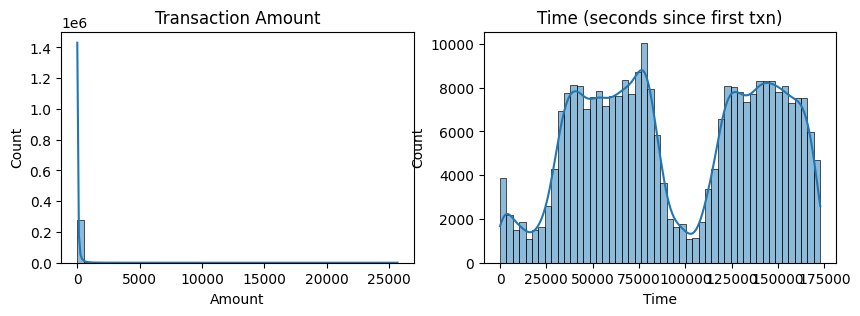

In [ ]:
section("Amount & Time distributions")
fig, ax = plt.subplots(1,2, figsize=(10,3))
sns.histplot(df["Amount"], bins=50, ax=ax[0], kde=True)
ax[0].set_title("Transaction Amount")
sns.histplot(df["Time"], bins=50, ax=ax[1], kde=True)
ax[1].set_title("Time (seconds since first txn)")
plt.show()

In [ ]:
X = df.drop(columns=["Class"]).copy()
y = df["Class"].astype(int)


In [ ]:
X["Amount_log1p"] = np.log1p(X["Amount"])

In [ ]:
X["Hour"] = (X["Time"] / 3600.0) % 24.0
X["Hour_sin"] = np.sin(2*np.pi*X["Hour"]/24.0)
X["Hour_cos"] = np.cos(2*np.pi*X["Hour"]/24.0)
X.drop(columns=["Hour"], inplace=True)

In [ ]:
df_sorted = df.sort_values("Time")
roll_window = 200
roll_mean = df_sorted["Amount"].rolling(roll_window, min_periods=1).mean().values
roll_std  = df_sorted["Amount"].rolling(roll_window, min_periods=1).std().fillna(0).values


In [ ]:
X["Amount_roll_mean_200"] = pd.Series(roll_mean, index=df_sorted.index).sort_index().values
X["Amount_roll_std_200"]  = pd.Series(roll_std,  index=df_sorted.index).sort_index().values


In [ ]:
X["Amount_over_rollmean"] = X["Amount"] / (X["Amount_roll_mean_200"] + 1e-6)
X["Amount_z_vs_roll"]     = (X["Amount"] - X["Amount_roll_mean_200"]) / (X["Amount_roll_std_200"] + 1e-6)


In [ ]:
base_poly_cols = ["Amount", "Amount_log1p"]

In [ ]:
v_subset = [c for c in df.columns if c.startswith("V")][:6]  # V1..V6
poly_cols = base_poly_cols + v_subset[:2]  # keep it light: Amount, Amount_log1p, V1, V2
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_arr = poly.fit_transform(X[poly_cols])
poly_names = poly.get_feature_names_out(poly_cols)
poly_df = pd.DataFrame(poly_arr, columns=poly_names, index=X.index)


In [ ]:
X_full = pd.concat([X, poly_df], axis=1)

In [ ]:
section("Engineered feature preview")
print("Columns:", len(X_full.columns))
display(X_full.head())


Engineered feature preview
Columns: 47


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,Amount,Amount_log1p,V1,V2,Amount Amount_log1p,Amount V1,Amount V2,Amount_log1p V1,Amount_log1p V2,V1 V2
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,149.62,5.014760,-1.359807,-0.072781,750.308407,-203.454343,-10.889519,-6.819107,-0.364980,0.098968
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,2.69,1.305626,1.191857,0.266151,3.512135,3.206096,0.715945,1.556120,0.347493,0.317214
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,378.66,5.939276,-1.358354,-1.340163,2248.966294,-514.354349,-507.466150,-8.067640,-7.959599,1.820416
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,123.50,4.824306,-0.966272,-0.185226,595.801756,-119.334556,-22.875412,-4.661590,-0.893587,0.178979
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,69.99,4.262539,-1.158233,0.877737,298.335106,-81.064734,61.432795,-4.937014,3.741387,-1.016624


In [ ]:
robust_scaler = RobustScaler()
X_robust = robust_scaler.fit_transform(X_full)

qt_scaler = QuantileTransformer(output_distribution="normal", random_state=SEED)
X_qt = qt_scaler.fit_transform(X_full)

In [ ]:
# Save feature column names
feature_list = list(X_full.columns)
joblib.dump(feature_list, "features_list.joblib")

# Download the file
files.download("features_list.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
os.makedirs("artifacts", exist_ok=True)
joblib.dump(robust_scaler, "artifacts/scaler_robust.joblib")
joblib.dump(qt_scaler, "artifacts/scaler_quantile.joblib")
joblib.dump(list(X_full.columns), "artifacts/features_list.joblib")


['artifacts/features_list.joblib']

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_robust, y, test_size=0.20, stratify=y, random_state=SEED
)

In [ ]:
X_train_norm = X_train_full[y_train_full == 0]

In [ ]:
val_frac = 0.2
split_idx = int((1 - val_frac) * len(X_train_norm))
X_val_norm = X_train_norm[split_idx:]
X_train_norm = X_train_norm[:split_idx]

print(f"Train normals: {X_train_norm.shape[0]}, Val normals: {X_val_norm.shape[0]}, Test: {X_test.shape[0]}")


Train normals: 181960, Val normals: 45491, Test: 56962


In [ ]:
def build_autoencoder(input_dim, hidden_dims=(64,32,16,8), dropout=0.1, l1=1e-7):
    inp = keras.Input(shape=(input_dim,))
    x = inp

    for h in hidden_dims:
        x = layers.Dense(h, activation="relu",
                         kernel_regularizer=regularizers.l2(1e-6))(x)
        x = layers.Dropout(dropout)(x)

    for h in hidden_dims[-2::-1]:
        x = layers.Dense(h, activation="relu")(x)
    out = layers.Dense(input_dim, activation="linear",
                       activity_regularizer=regularizers.l1(l1))(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return model

In [ ]:
ARCHS = {
    "Shallow_16_8":       dict(hidden_dims=(16,8), dropout=0.05),
    "Medium_32_16_8":     dict(hidden_dims=(32,16,8), dropout=0.1),
    "Deep_64_32_16_8":    dict(hidden_dims=(64,32,16,8), dropout=0.1),
    "WIDE_128_64_32_16":  dict(hidden_dims=(128,64,32,16), dropout=0.15),
    "Narrow_Bottleneck4": dict(hidden_dims=(32,16,4), dropout=0.1),
}


In [ ]:
EPOCHS = 60
BATCH  = 2048

histories = {}
models    = {}


In [ ]:
for name, cfg in ARCHS.items():
    print(f"\nTraining {name} ...")
    model = build_autoencoder(X_train_norm.shape[1], **cfg)
    es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
    ckpt_path = f"artifacts/ae_{name}.keras"
    mc = keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_loss")
    hist = model.fit(
        X_train_norm, X_train_norm,
        validation_data=(X_val_norm, X_val_norm),
        epochs=EPOCHS, batch_size=BATCH, shuffle=True,
        callbacks=[es, mc], verbose=0
    )
    histories[name] = hist
    models[name] = keras.models.load_model(ckpt_path)



Training Shallow_16_8 ...

Training Medium_32_16_8 ...

Training Deep_64_32_16_8 ...

Training WIDE_128_64_32_16 ...

Training Narrow_Bottleneck4 ...


In [ ]:
def recon_errors(model, X):
    pred = model.predict(X, verbose=0)
    return np.mean(np.square(X - pred), axis=1)


In [ ]:
def metrics_at_threshold(err, y_true, thr):
    y_pred = (err > thr).astype(int)
    return {
        "accuracy":  accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall":    recall_score(y_true, y_pred, zero_division=0),
        "f1":        f1_score(y_true, y_pred, zero_division=0),
        "cm":        confusion_matrix(y_true, y_pred),
    }


In [ ]:
def sweep_best_threshold(err_train_norm, err_test, y_test, percentiles=np.linspace(80, 99.9, 40)):
    """Pick threshold on train normals via percentile; evaluate on test. Return best by F1."""
    recs = []
    for p in percentiles:
        thr = np.percentile(err_train_norm, p)
        m = metrics_at_threshold(err_test, y_test, thr)
        recs.append({"percentile": p, "threshold": thr, **{k:v for k,v in m.items() if k != "cm"}})
    df_thr = pd.DataFrame(recs)
    idx = df_thr["f1"].idxmax()
    return df_thr, df_thr.loc[idx, "threshold"]

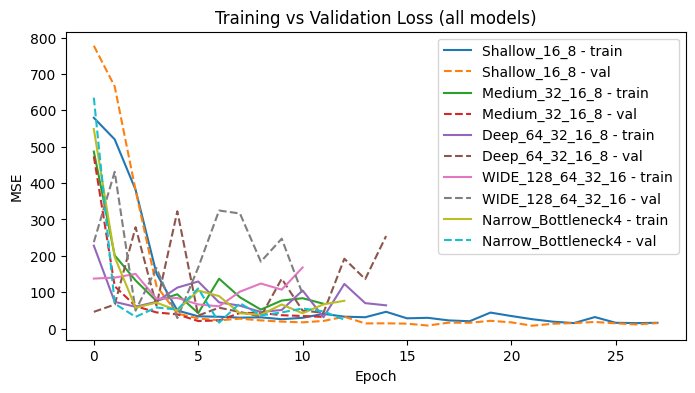

In [ ]:
results_table = []

plt.figure(figsize=(8,4))
for name, hist in histories.items():
    plt.plot(hist.history["loss"], label=f"{name} - train")
    plt.plot(hist.history["val_loss"], linestyle="--", label=f"{name} - val")
plt.title("Training vs Validation Loss (all models)")
plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.legend()
plt.show()


Evaluating Shallow_16_8


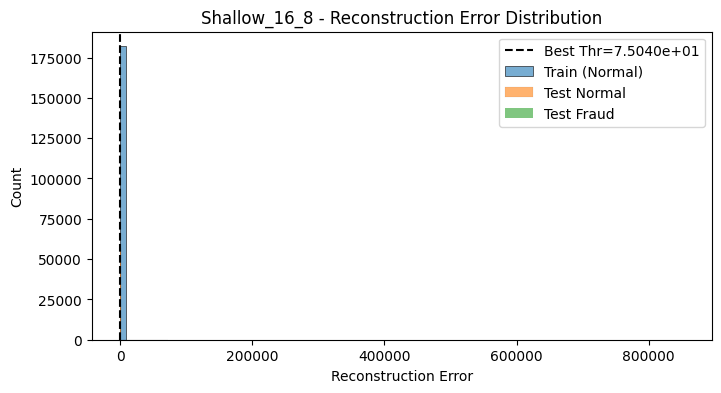

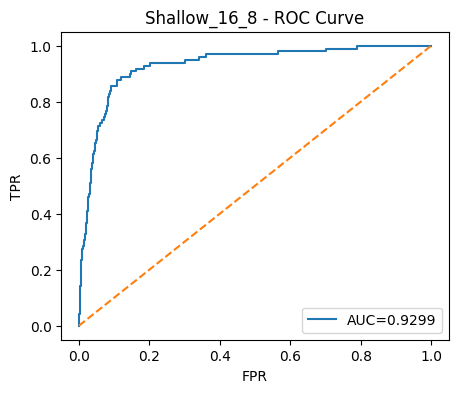

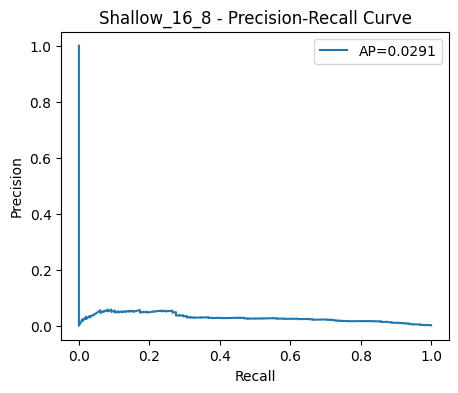

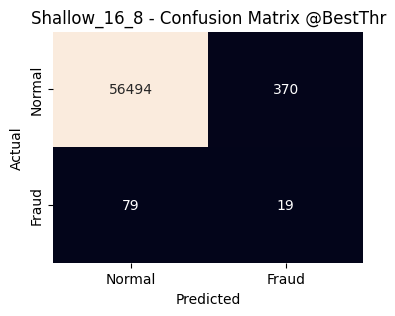

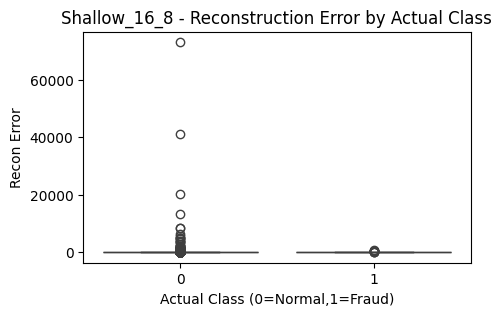

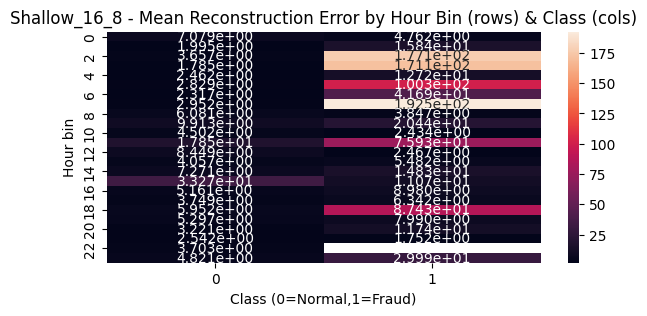


Evaluating Medium_32_16_8


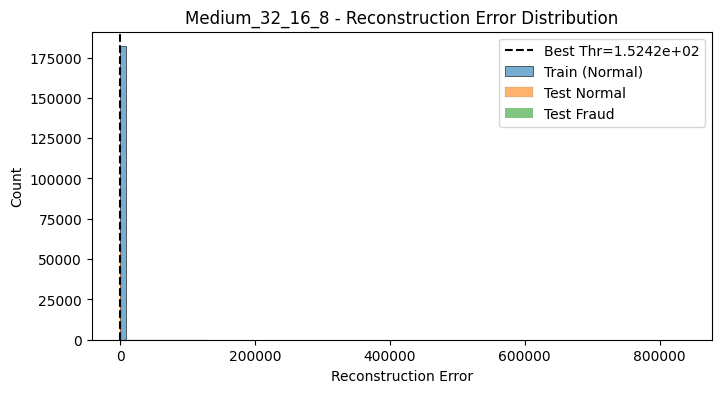

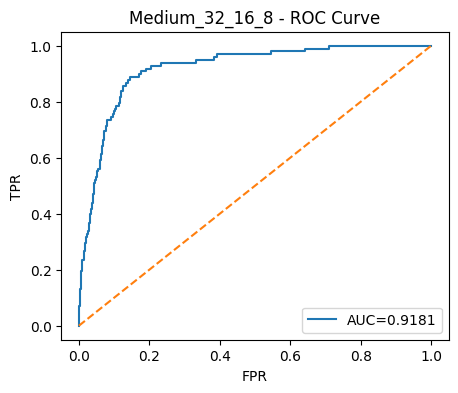

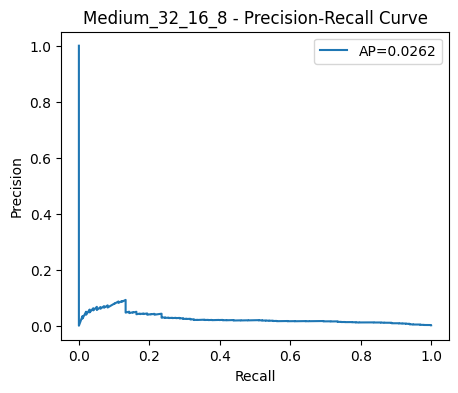

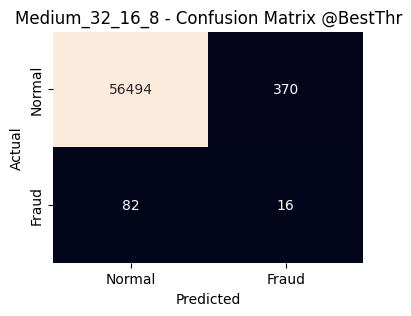

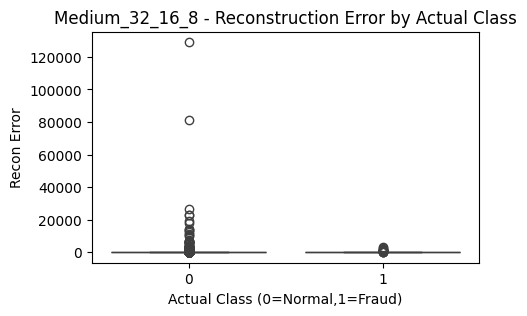

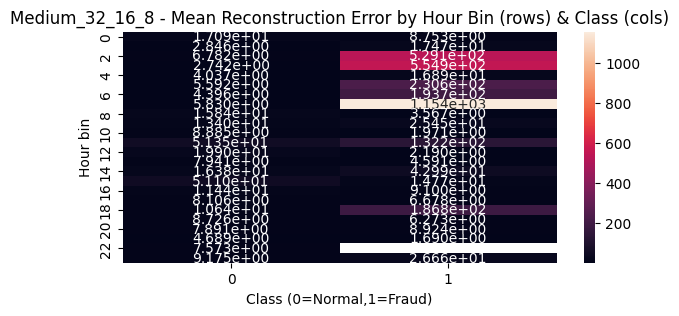


Evaluating Deep_64_32_16_8


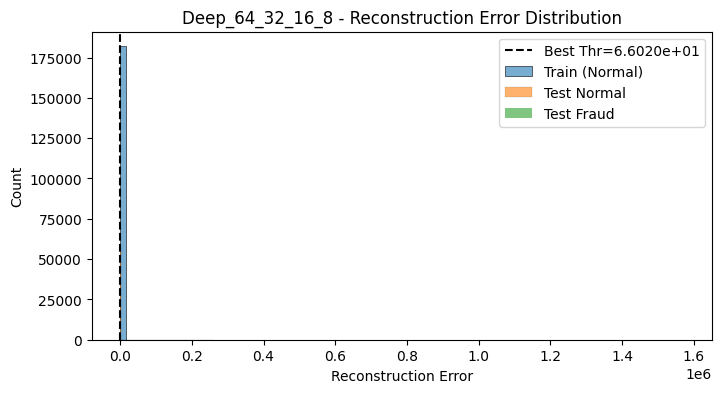

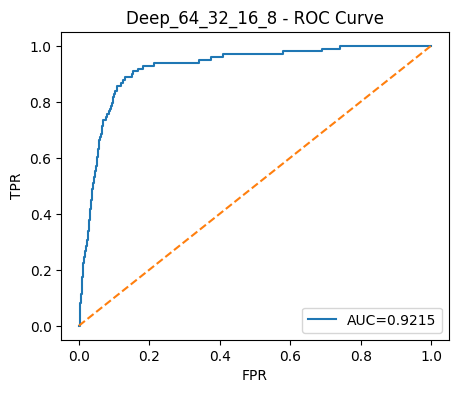

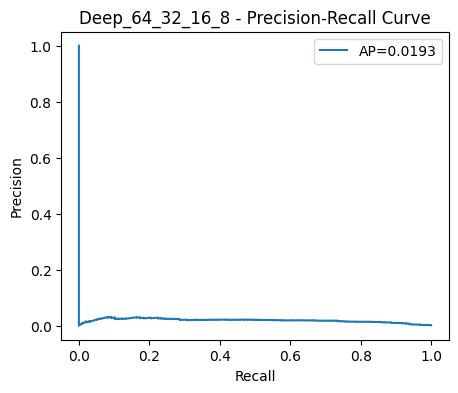

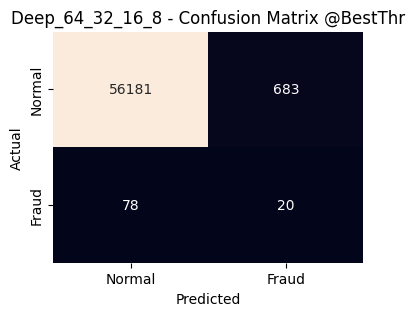

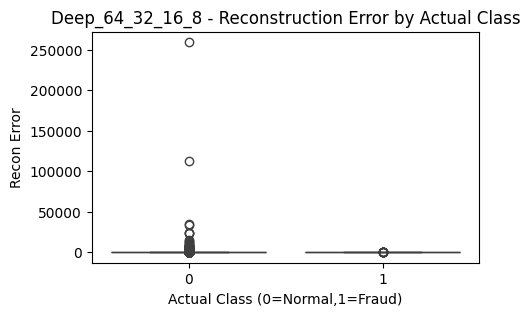

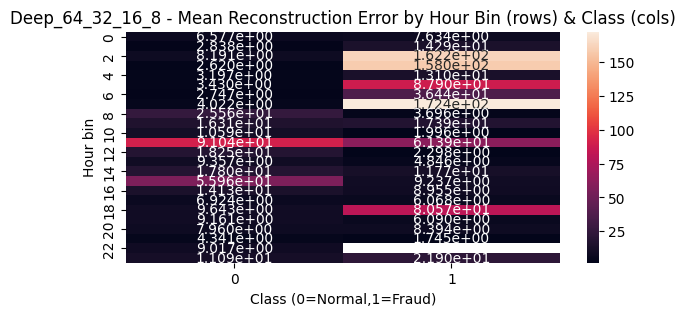


Evaluating WIDE_128_64_32_16


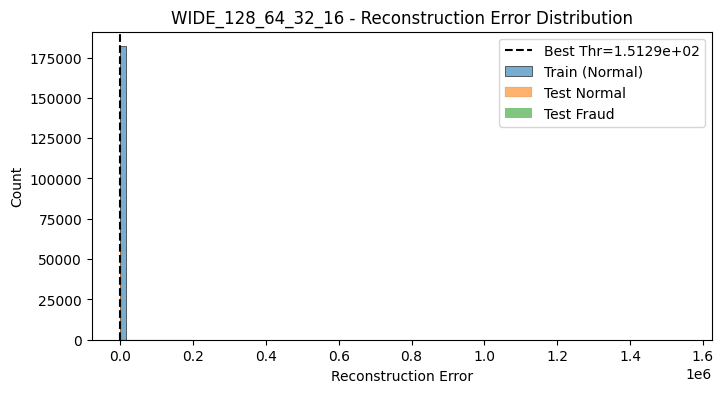

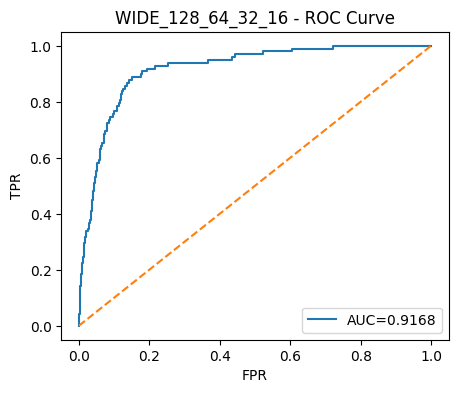

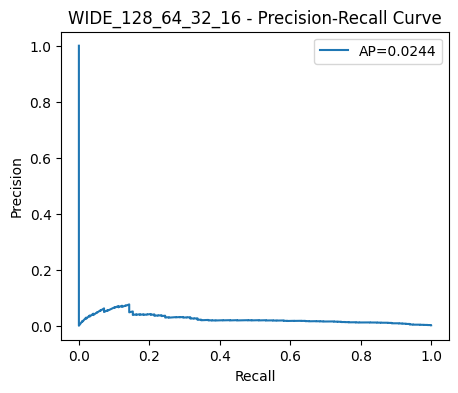

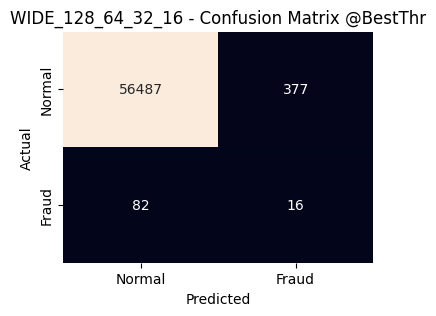

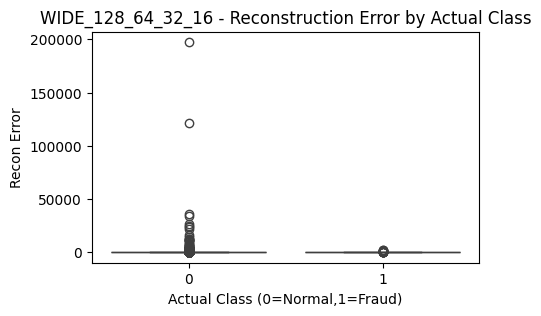

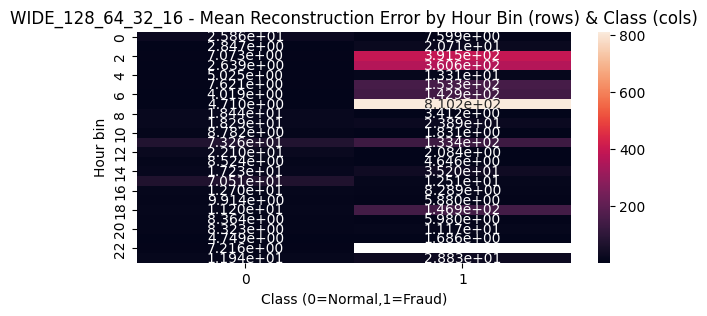


Evaluating Narrow_Bottleneck4


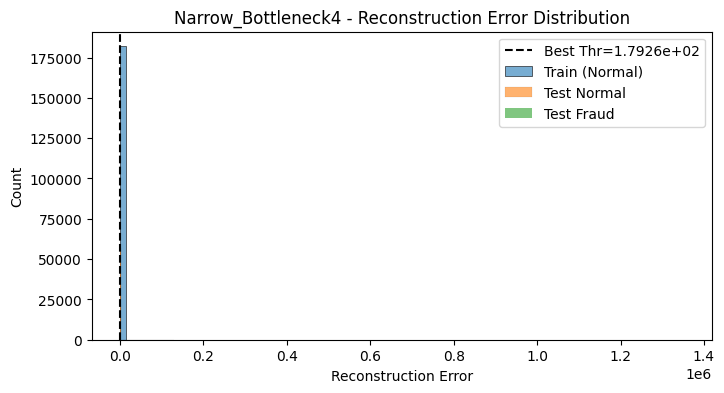

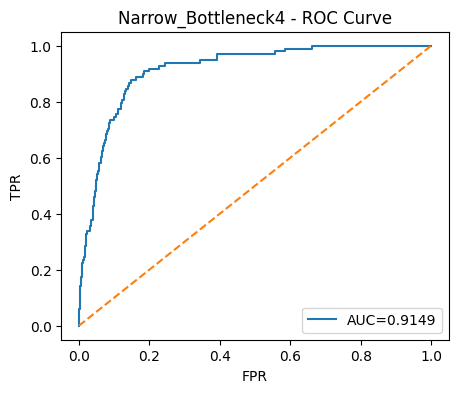

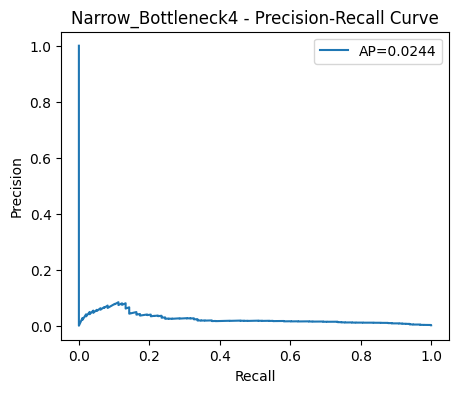

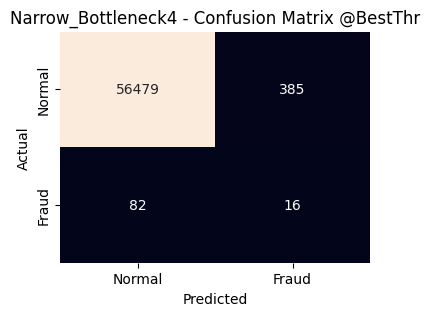

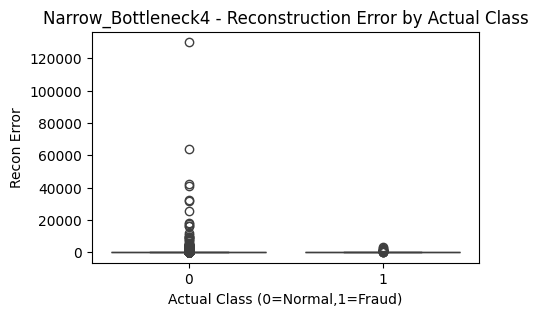

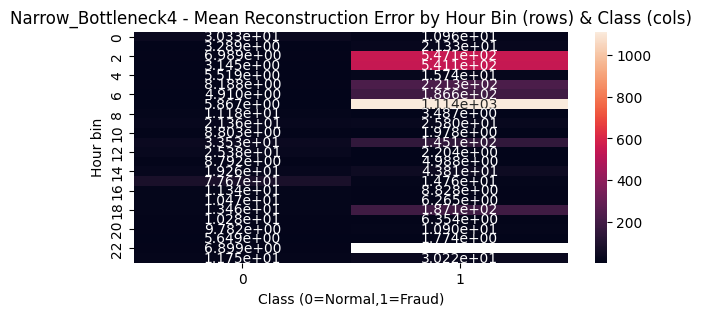

In [ ]:
for name, model in models.items():
    section(f"Evaluating {name}")

    err_train_norm = recon_errors(model, X_train_norm)
    err_test       = recon_errors(model, X_test)


    df_thr, best_thr = sweep_best_threshold(err_train_norm, err_test, y_test)
    best_row = df_thr.loc[df_thr["f1"].idxmax()].to_dict()

    roc = roc_auc_score(y_test, err_test)
    ap  = average_precision_score(y_test, err_test)

    y_pred_best = (err_test > best_thr).astype(int)
    cm = confusion_matrix(y_test, y_pred_best)

    results_table.append({
        "model": name,
        "best_percentile": best_row["percentile"],
        "threshold": best_thr,
        "accuracy": best_row["accuracy"],
        "precision": best_row["precision"],
        "recall": best_row["recall"],
        "f1": best_row["f1"],
        "roc_auc": roc,
        "pr_auc": ap
    })

    plt.figure(figsize=(8,4))
    sns.histplot(err_train_norm, bins=100, label="Train (Normal)", alpha=0.6)
    sns.histplot(err_test[y_test==0], bins=100, label="Test Normal", alpha=0.6)
    sns.histplot(err_test[y_test==1], bins=100, label="Test Fraud",  alpha=0.6)
    plt.axvline(best_thr, color="k", linestyle="--", label=f"Best Thr={best_thr:.4e}")
    plt.title(f"{name} - Reconstruction Error Distribution")
    plt.xlabel("Reconstruction Error"); plt.ylabel("Count"); plt.legend()
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, err_test)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={roc:.4f}")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title(f"{name} - ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
    plt.show()

    prec, rec, _ = precision_recall_curve(y_test, err_test)
    plt.figure(figsize=(5,4))
    plt.plot(rec, prec, label=f"AP={ap:.4f}")
    plt.title(f"{name} - Precision-Recall Curve"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
    plt.show()

    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=["Normal","Fraud"], yticklabels=["Normal","Fraud"])
    plt.title(f"{name} - Confusion Matrix @BestThr")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

    plt.figure(figsize=(5,3))
    sns.boxplot(x=y_test, y=err_test)
    plt.title(f"{name} - Reconstruction Error by Actual Class")
    plt.xlabel("Actual Class (0=Normal,1=Fraud)"); plt.ylabel("Recon Error")
    plt.show()

    test_idx = y_test.index if isinstance(y_test, pd.Series) else pd.RangeIndex(len(y_test))
    idx_all = np.arange(len(df))
    _, idx_test = train_test_split(idx_all, test_size=0.20, stratify=y, random_state=SEED)
    hours = ((df.iloc[idx_test]["Time"] / 3600.0) % 24.0).values
    bins = np.linspace(0,24,25)
    hour_bins = np.digitize(hours, bins) - 1
    heat_df = pd.DataFrame({"hour_bin": hour_bins, "err": err_test, "fraud": y_test})
    plt.figure(figsize=(7,3))
    piv = heat_df.pivot_table(values="err", index="hour_bin", columns="fraud", aggfunc="mean")
    sns.heatmap(piv, annot=True, fmt=".3e", cbar=True)
    plt.title(f"{name} - Mean Reconstruction Error by Hour Bin (rows) & Class (cols)")
    plt.xlabel("Class (0=Normal,1=Fraud)"); plt.ylabel("Hour bin")
    plt.show()


Model comparison (sorted by F1 at best threshold)


,model,best_percentile,threshold,accuracy,precision,recall,f1,roc_auc,pr_auc
0,Shallow_16_8,99.389744,75.039702,0.992118,0.048843,0.193878,0.078029,0.929941,0.029075
1,Medium_32_16_8,99.389744,152.418876,0.992065,0.041451,0.163265,0.066116,0.918095,0.026177
2,WIDE_128_64_32_16,99.389744,151.287759,0.991942,0.040712,0.163265,0.065173,0.916762,0.024369
3,Narrow_Bottleneck4,99.389744,179.257956,0.991802,0.039900,0.163265,0.064128,0.914850,0.024408
4,Deep_64_32_16_8,98.879487,66.020267,0.986640,0.028450,0.204082,0.049938,0.921516,0.019275


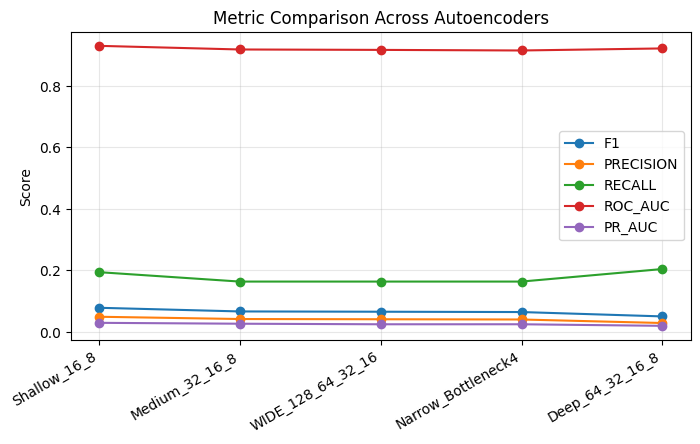

In [ ]:
res_df = pd.DataFrame(results_table).sort_values("f1", ascending=False).reset_index(drop=True)
section("Model comparison (sorted by F1 at best threshold)")
display(res_df)

plt.figure(figsize=(8,4))
for metric in ["f1","precision","recall","roc_auc","pr_auc"]:
    plt.plot(res_df["model"], res_df[metric], marker="o", label=metric.upper())
plt.xticks(rotation=30, ha="right"); plt.grid(alpha=0.3)
plt.legend(); plt.title("Metric Comparison Across Autoencoders"); plt.ylabel("Score")
plt.show()

In [ ]:
best_model_name = res_df.iloc[0]["model"]
best_model = models[best_model_name]
section(f"Latent space visualization — Best model: {best_model_name}")


Latent space visualization — Best model: Shallow_16_8


In [ ]:
def build_encoder_from_autoencoder(autoencoder):
    encoder_layers = []
    for layer in autoencoder.layers:
        encoder_layers.append(layer)
        if layer.name.startswith("bottleneck"):
            break
    encoder = tf.keras.Sequential(encoder_layers, name="encoder")
    return encoder

encoder = build_encoder_from_autoencoder(best_model)


In [ ]:
Z_test = encoder.predict(X_test, verbose=0)
pca_2 = PCA(n_components=2, random_state=SEED).fit_transform(Z_test)
umap_2 = UMAP(n_components=2, random_state=SEED, n_neighbors=30, min_dist=0.1).fit_transform(Z_test)


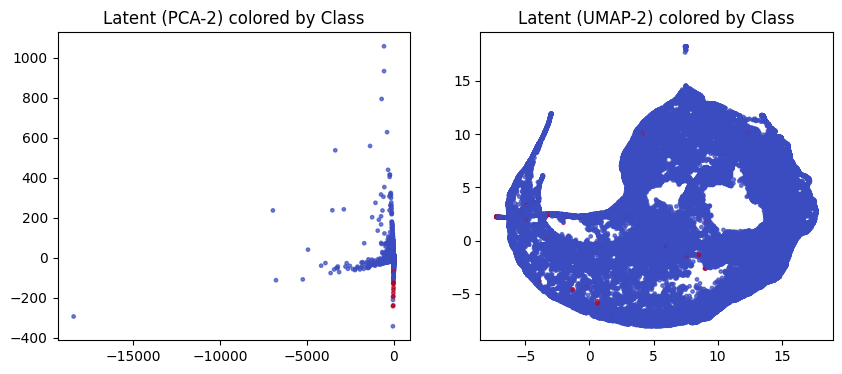

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(pca_2[:,0], pca_2[:,1], c=y_test, s=6, alpha=0.7, cmap="coolwarm")
ax[0].set_title("Latent (PCA-2) colored by Class")
ax[1].scatter(umap_2[:,0], umap_2[:,1], c=y_test, s=6, alpha=0.7, cmap="coolwarm")
ax[1].set_title("Latent (UMAP-2) colored by Class")
plt.show()


In [ ]:
best_ckpt_path = f"artifacts/ae_{best_model_name}.keras"
best_export_path = "artifacts/best_autoencoder.keras"
best_model.save(best_export_path)
print("Saved best autoencoder to:", best_export_path)
print("Also saved: artifacts/scaler_robust.joblib, artifacts/scaler_quantile.joblib, artifacts/features_list.joblib")


Saved best autoencoder to: artifacts/best_autoencoder.keras
Also saved: artifacts/scaler_robust.joblib, artifacts/scaler_quantile.joblib, artifacts/features_list.joblib


In [ ]:
def score_new_dataframe(df_new, scaler_path="artifacts/scaler_robust.joblib",
                        model_path="artifacts/best_autoencoder.keras"):
    """Given a raw DF like creditcard.csv (no Class needed), engineer features, scale, score with AE."""

    Xn = df_new.copy()
    if "Class" in Xn.columns:
        Xn = Xn.drop(columns=["Class"])

    Xn["Amount_log1p"] = np.log1p(Xn["Amount"])
    Xn["Hour"] = (Xn["Time"] / 3600.0) % 24.0
    Xn["Hour_sin"] = np.sin(2*np.pi*Xn["Hour"]/24.0)
    Xn["Hour_cos"] = np.cos(2*np.pi*Xn["Hour"]/24.0)
    Xn.drop(columns=["Hour"], inplace=True)


    Xn_sorted = Xn.sort_values("Time")
    roll_mean = Xn_sorted["Amount"].rolling(200, min_periods=1).mean().values
    roll_std  = Xn_sorted["Amount"].rolling(200, min_periods=1).std().fillna(0).values
    Xn["Amount_roll_mean_200"] = pd.Series(roll_mean, index=Xn_sorted.index).sort_index().values
    Xn["Amount_roll_std_200"]  = pd.Series(roll_std,  index=Xn_sorted.index).sort_index().values
    Xn["Amount_over_rollmean"] = Xn["Amount"] / (Xn["Amount_roll_mean_200"] + 1e-6)
    Xn["Amount_z_vs_roll"]     = (Xn["Amount"] - Xn["Amount_roll_mean_200"]) / (Xn["Amount_roll_std_200"] + 1e-6)

    poly_cols = ["Amount", "Amount_log1p"]
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    poly_arr = poly.fit_transform(Xn[poly_cols])
    poly_names = poly.get_feature_names_out(poly_cols)
    poly_df = pd.DataFrame(poly_arr, columns=poly_names, index=Xn.index)
    Xn_full = pd.concat([Xn, poly_df], axis=1)

    feat_list = joblib.load("artifacts/features_list.joblib")
    for c in feat_list:
        if c not in Xn_full.columns:
            Xn_full[c] = 0.0
    Xn_full = Xn_full[feat_list]

    scaler = joblib.load(scaler_path)
    Xn_scaled = scaler.transform(Xn_full)

    model = keras.models.load_model(model_path)
    recon = np.mean(np.square(Xn_scaled - model.predict(Xn_scaled, verbose=0)), axis=1)
    return recon

In [ ]:
section("Scoring example on test split using best model:")
best_model = keras.models.load_model(best_export_path)
err_test_best = recon_errors(best_model, X_test)


Scoring example on test split using best model:


In [ ]:
err_train_norm_best = recon_errors(best_model, X_train_norm)
thr_95 = np.percentile(err_train_norm_best, 95)
y_pred = (err_test_best > thr_95).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))
print("F1:", f1_score(y_test, y_pred, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, err_test_best))
print("PR-AUC:", average_precision_score(y_test, err_test_best))


Accuracy: 0.9480530880235947
Precision: 0.021731862253426947
Recall: 0.6632653061224489
F1: 0.04208481709291033
ROC-AUC: 0.929940610177667
PR-AUC: 0.02907498188256063


In [ ]:
import os
import joblib

os.makedirs("artifacts", exist_ok=True)

best_model.save("artifacts/best_autoencoder.keras")

joblib.dump(robust_scaler, "artifacts/scaler_robust.joblib")

['artifacts/scaler_robust.joblib']

In [ ]:
from google.colab import files

files.download("artifacts/best_autoencoder.keras")
files.download("artifacts/scaler_robust.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>